The Meterstick package provides a concise and flexible syntax to describe and execute
routine data analysis tasks. This notebooks explains how to implement custom `Metric`s or `Operation`s in Meterstick.

# For External users

You can open this notebook in [Google Colab](https://colab.research.google.com/github/google/meterstick/blob/master/meterstick_custom_metrics.ipynb).

## Installation

You can install from pip for the stable version

In [ ]:
!pip install meterstick

or from GitHub for the latest version.

In [ ]:
!git clone https://github.com/google/meterstick.git
import sys, os
sys.path.append(os.getcwd())

# Setup

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

from meterstick import *

In [ ]:
np.random.seed(0)
platform = ('Desktop', 'Mobile', 'Tablet')
exprs = ('ctrl', 'expr')
country = ('US', 'non-US')
size = 80
impressions = np.random.randint(10, 20, size)
clicks = impressions * 0.1 * np.random.random(size)
df = pd.DataFrame({'impressions': impressions, 'clicks': clicks})
df['platform'] = np.random.choice(platform, size=size)
df['expr_id'] = np.random.choice(exprs, size=size)
df['country'] = np.random.choice(country, size=size)
df['cookie'] = np.random.choice(range(3), size=size)

df.loc[df.country == 'US', 'clicks'] *= 2
df.loc[(df.country == 'US') & (df.platform == 'Desktop'), 'impressions'] *= 4
df.head()

,impressions,clicks,platform,expr_id,country,cookie
0,15,2.985899,Mobile,expr,US,0
1,10,1.163701,Tablet,ctrl,US,1
2,52,1.077358,Desktop,expr,US,2
3,52,1.234214,Desktop,expr,US,0
4,17,1.059967,Mobile,ctrl,non-US,0


# Level of Caching

There are two levels of caching in `Meterstick`.
1. Instance level: different `Metric` instances don't share the same result.
1. Class level: different `Metric` classes don't share the same result while different instances of the same class might, *if and only if they have the same attributes that matters*.

Class level caching is a bit tricky so by default it's only enabled for built-in `Metric`s, and custom `Metric`s only enjoy instance level caching. If you want to enable class level caching on a custom `Metric`, you need to manually set `cache_across_instances` to `True` and register all attributes that have impat on the result into `additional_fingerprint_attrs`.

In [ ]:
# SumWithTrace has instance level caching.
class SumWithTrace(Sum):
  def __init__(self, *args, **kwargs):
    super(SumWithTrace, self).__init__(*args, **kwargs)

  def compute_through(self, data, split_by):
    print('Computing %s...' % self.name)
    return super(SumWithTrace, self).compute_through(data, split_by)

sum_clicks = SumWithTrace('clicks')
ctr = sum_clicks / SumWithTrace('impressions')
MetricList((sum_clicks, ctr)).compute_on(df)

Computing sum(clicks)...
Computing sum(impressions)...


,sum(clicks),sum(clicks) / sum(impressions)
0,97.249368,0.056871


In [ ]:
# SumWithTrace doesn't have class level caching. Below sum of clicks is computed
# twice because we have two instances of it.
sum_clicks = SumWithTrace('clicks')
ctr = SumWithTrace('clicks') / SumWithTrace('impressions')
MetricList((sum_clicks, ctr)).compute_on(df)

Computing sum(clicks)...
Computing sum(clicks)...
Computing sum(impressions)...


,sum(clicks),sum(clicks) / sum(impressions)
0,97.249368,0.056871


In [ ]:
# With class level caching enabled, SumWithClassLevelCaching('clicks') will only
# be computed once.
class SumWithClassLevelCaching(Metric):

  def __init__(self, var):
    self.var = var
    # Register all attributes that have impact to the result number.
    super(SumWithClassLevelCaching, self).__init__(
        name=f'Sum of {var}', additional_fingerprint_attrs=['var']
    )
    # Enable class level caching.
    self.cache_across_instances = True

  def compute(self, data):
    print('Computing %s...' % self.name)
    return df[self.var].sum()


sum_clicks = SumWithClassLevelCaching('clicks')
ctr = SumWithClassLevelCaching('clicks') / SumWithClassLevelCaching(
    'impressions'
)
MetricList((sum_clicks, ctr)).compute_on(df)

Computing Sum of clicks...
Computing Sum of impressions...


,Sum of clicks,Sum of clicks / Sum of impressions
0,97.249368,0.056871


In [ ]:
# Check additional_fingerprint_attrs for what attributes are registered.
sum_clicks.additional_fingerprint_attrs

{'var'}

#Custom Metric
We provide many Metrics out of box but we understand there are cases you need more, so we make it easy for you to write you own Metrics.
First you need to understand the dataflow of a DataFrame when it's passed to compute_on(). The dataflow looks like this.

		    <-------------------------------------------compute_on(handles caching)---------------------------------------------->
		    <-------------------------------------compute_through----------------------------------->                            |
		    |                                              <------compute_slices------>             |                            |
		    |                                              |-> slice1 -> compute |    |             |                            |
		df -> df.query(where) -> precompute -> split_data -|-> slice2 -> compute | -> pd.concat  -> postcompute -> manipulate -> final_compute
		                                                   |-> ...			   |

In summary, compute() operates on a slice of data and hence only takes one arg, df. While precompute(), postcompute(), compute_slices(), compute_through() and final_compute() operate on the whole DataFrame so they take the df that has been processed by the dataflow till them and the split_by passed to compute_on(). final_compute() also has access to the original df passed to compute_on() for you to make additional manipulation. manipulate() does common data manipulation like melting and cleaning. Besides wrapping all the computations above, compute_on() also caches the result from compute_through(). Please refer to the section of Caching for more details.

Depending on your case, you can overwrite all the methods, but we suggest you NOT to overwrite compute_on() because it might mess up the caching mechanism, nor manipulate(), because it might not work well with other Metrics' data manipulation. Here are some rules to help you decide.
1. Read the `Caching` section above first.
1. If your Metric has no vectorization over slices, overwrite compute() which only takes one arg, df. To overwrite, you can either create a new class inheriting from Metric or just pass a lambda function into Metric.
2. If you have vectorization logic over slices, overwrite compute_slices().
3. As compute() operates on a slice of data, it doesn't have access to the columns to split_by and the index value of the slice. If you need them, overwrite compute_with_split_by(self, df, split_by, slice_name), which is just a wrapper of compute(), but has access to split_by and the value of current slice, slice_name.
4. The data passed into manipulate() should be a number, a pd.Series, or a wide/unmelted pd.DataFrame.
5. split_data() returns (sub_dataframe, corresponding slice value). You might want to overwrite it for non-vectorized Operations. See section Linear Regression for examples.

Also there are some requirements.
1. Your Metric shouldn't change the input DataFrame inplace or it might not work with other Metrics.
2. Your Metric shouldn't rely on the index of the input DataFrame if you want it to work with Jackknife. The reason is Jackknife might reset the index.


## No Vectorization

In [ ]:
class CustomSum(Metric):

  def __init__(self, var):
    name = 'custom sum(%s)' % var
    super(CustomSum, self).__init__(name, additional_fingerprint_attrs=['var'])
    self.var = var
    # For custom Metrics, class-level caching needs to be manually enabled.
    # See the Caching section for more information.
    self.cache_across_instances = True

  def compute(self, df):
    return df[self.var].sum()


CustomSum('clicks').compute_on(df, 'country')

,custom sum(clicks)
country,
US,69.095494
non-US,28.153874


In [ ]:
Sum('clicks').compute_on(df, 'country')

,sum(clicks)
country,
US,69.095494
non-US,28.153874


CustomSum doesn't have vectorization. It loops through the DataFrame and sum on every slice. As the result, it's slower than vectorized summation.

In [ ]:
%%timeit
CustomSum('clicks').compute_on(df, 'country')

1000 loops, best of 5: 1.56 ms per loop


In [ ]:
%%timeit
Sum('clicks').compute_on(df, 'country')

1000 loops, best of 5: 758 µs per loop


In [ ]:
%%timeit
df.groupby('country')['clicks'].sum()

1000 loops, best of 5: 467 µs per loop


## With Vectorization

We can do better. Let's implement a Sum with vectorization.

In [ ]:
class VectorizedSum(Metric):

  def __init__(self, var):
    name = 'vectorized sum(%s)' % var
    super(VectorizedSum, self).__init__(
        name=name, additional_fingerprint_attrs=['var']
    )
    self.var = var
    # For custom Metrics, class-level caching needs to be manually enabled.
    # See the Caching section for more information.
    self.cache_across_instances = True

  def compute_slices(self, df, split_by):
    if split_by:
      return df.groupby(split_by)[self.var].sum()
    return df[self.var].sum()


VectorizedSum('clicks').compute_on(df, 'country')

,vectorized sum(clicks)
country,
US,69.095494
non-US,28.153874


In [ ]:
%%timeit
VectorizedSum('clicks').compute_on(df, 'country')

1000 loops, best of 5: 749 µs per loop


## Precompute, postcompute and final_compute

They are useful when you need to preprocess and postprocess the data.

In [ ]:
class USOnlySum(Sum):

  def precompute(self, df, split_by):
    return df[df.country == 'US']

  def postcompute(self, data, split_by):
    print('Inside postcompute():')
    print('Input data: ', data)
    print('Input split_by: ', split_by)
    print('\n')
    return data

  def final_compute(self, res, melted, return_dataframe, split_by, df):
    # res is the result processed by the dataflow till now. df is the original
    # DataFrme passed to compute_on().
    print('Inside final_compute():')
    for country in df.country.unique():
      if country not in res.index:
        print('Country "%s" is missing!' % country)
    return res


USOnlySum('clicks').compute_on(df, 'country')

Inside postcompute():
Input data:  country
US    69.095494
Name: clicks, dtype: float64
Input split_by:  ['country']


Inside final_compute():
Country "non-US" is missing!


,sum(clicks)
country,
US,69.095494


##Custom Operation
Writing a custom `Operation` is more complex. Typically an `Operation` needs to compute some util `Metric`s. A common one is its child `Metric`. The tricky part is how to make sure the additional computations interact correctly with the cache. First take a look at the Caching section above to understand how caching works in `Meterstick`. Then here is a decision tree to help you.


                +-----------------------------------+                            
                | Want the util Metric to share     |
                | caching with other Metrics?       |-----------→                
                +-----------------------------------+           ↓                
                                  ↓                             |                
                                  |                             |                
                                  Y                             N                
                                  ↓                             |                
                 +-------------------------------+              |                
                 |Using the data from the input  |              |                
                 |of the method being overridden?|              |                
                 +-------------------------------+              ↓                
                                  ↓                   +----------------------+
                                  |                   |Call compute_on() or  |
                                  |------------N----->|compute_on_sql() on   |
                                  |                   |the util Metric. Set  |
                                  Y                   |precomputable_in_jk_bs|
                                  |                   |to False.             |
                                  |                   +----------------------+
                                  ↓                                              
                 +-------------------------------+                               
                 |Is the Metric the child Metric?|                               
                 +-------------------------------+                               
                                  ↓                                              
                        Y---------|--------N                                     
                        ↓                  ↓                                     
             +----------------------+  +-------------------------------+         
             |Use compute_child()   |  |Use compute_util_metric_on()   |         
             |or compute_child_sql()|  |or compute_util_metric_on_sql()|         
             +----------------------+  +-------------------------------+

1. All `Metric` instances in one computation point to the same cache, so the first
question is do you need your util `Metric` to connect to the cache to share the caching. If not, you can just call the `compute_on` or `compute_on_sql` on the util `Metric`. You also need to set the `precomputable_in_jk` attribute of the `Operation` to `False`. The reason is explained below.
1. We don't check if the input data is consistent when using caching so users need to make sure the util `Metric` is computed on the same data as other `Metric`s are. If the util `Metric` is computed on the data passed to the method your are overriding, it's safe to use the recommended methods below that will save the result to cache.
1. A very common scenerio is that an `Operation` needs to compute the child `Metric` first. Use `compute_child` or `compute_child_sql` to do so. Oftentimes the child `Metric` needs to be computed with an extended `split_by`, for example, `PercentChange('grp', 'base', Sum(x)).compute_on(data, 'foo')` will need to compute `Sum(x).compute_on(data, ['foo', 'grp'])` first. The recommended way is that you register the extra dimensions, `grp` in the example, in `__init__()`. Then the default `compute_child` and `compute_child_sql` will return the result of the child `Metric` you want. You only need to implement the `compute_on_children` then.
1. The extra dimensions are stored in `self.extra_split_by`. There is another attribute `extra_index` which stores the indexes the `Operation` adds. When unspecified, it will be set to the value of `self.extra_split_by`. For complex `Operations` the two can differ. For example, in the computation of `MH(condition_column, baseline_key, stratified_by, child)`, we need to compute `child.compute_on(df, split_by + [condition_column, stratified_by])` so the `extra_split_by` is `[condition_column, stratified_by]`. However, `stratified_by` won't show up in the final result so you need to explicitly set the `extra_index` to `condition_column`.
1. If you need to store part of the extra dimensions in another attribute, make it a property that is dynamically computed from `extra_split_by` or `extra_index`. Do NOT make it statically assigned in the `__init__`. For example, in `MH`, we don't do
```
def __init__(self, ..., stratified_by, ...):
    ...
    self.stratified_by = stratified_by
```
Instead, we do
```
@property
def stratified_by(self):
    return self.extra_split_by[len(self.extra_index):]
@stratified_by.setter
def stratified_by(self, stratified_by):
    self.extra_split_by[len(self.extra_index):] = stratified_by
```
The reason is that in SQL generation, if the dimensions in the attribute have any special character, they will get sanitized so queries based on them need to be adjusted. We will take care of `extra_split_by` and `extra_index` but we don't have knowledge about your attributes so if they are static the SQL query might be invalid.
1. When you need to manually construct the extended `split_by`, make the extra dimensions come after the original `split_by`. That's how we do it for all built-in `Operation`s so the caching could be maximized.
1. Try to vectorize the `Operation` as much as possible. If it's hard to vectorize, often you can at least compute the child `Metric` in a vectorized way by calling `compute_child`. Then implement `compute(self, df_slice)` which handles a slice of the data returned by the child `Metric`. See `CumulativeDistribution` below for an example.
1. When you need to compute a util `Metric` other than the child `Metric`, use `compute_util_metric_on` or `compute_util_metric_on_sql`. `compute_child` and `compute_child_sql` are just wrappers of them for the child `Metric`.
1. If the `Operation` has additional attributes that affect the computation logic, register them to `additional_fingerprint_attrs`. The `fingerprint` contains all the attributes that decide the result of a Metric except the name. In other words, if two instances have the same fingerprint, they should always compute to the same result, with the only exception that the column names can be different.
1. As explained in the `Jackknife` and `Bootstrap` section, we take shortcuts when leaf `Metric`s are `Sum` and/or `Count` or can be expressed by them. It speeds up the computation. If you want your `Operation` to work with `Jackknife`/`Bootstrap` in a fast way, try to delegate the computations to `Sum`, `Count`, or `Metric`s that can be expressed by them, which includes `Mean`, `Dot`, `Variance`, `StandardDeviation`, `CV`, `Correlation` and `Cov`. See section Linear Regression for a performance comparison.
1. When taking the shortcut, `Jackknife`/`Bootstrap` will just emit `None` as the resampled data. The reason is that the LOO estimates have been precomputed and saved in cache so there is no need to emit real data. This will be a problem for you if you ever call `compute_on` or `compute_on_sql` in your computation logic. You can either
      * ensure that your computation still works when the input data is `None`.
      * set attribute `precomputable_in_jk_bs` to `False`, which will stop `Jackknife`/`Bootstrap` from taking the shortcuts, and make the computation slower.
1. An `Operation` might not be precomputable even all the leaf `Metric`s are `Sum` and/or `Count`. It's not easy to decide. The easiest way to check is just set the `precomputable_in_jk_bs` to `True` and try `Metric`s like

  - `Jackknife(..., Operation(Dot('x', 'y', where='x>2')))` and
  - `Jackknife(..., Operation(Dot('x', 'y', where='x>2')), enable_optimization=False)`.

  If the first one computes and gives the same result to the second one, the `Operation` is precomputable. See the doc of `Operation` for the attribute for
more details if you're curious.

That's a lot to digest. Let's see two examples. Below we implement `Distribution` with and without vectorization.

In [ ]:
class DistributionWithVectorization(Operation):
  """Computes the normalized values of a Metric over column(s)."""

  def __init__(
      self,
      over: Union[Text, List[Text]],
      child: Optional[Metric] = None,
      name_tmpl: Text = 'Distribution of {}',
      **kwargs,
  ):
    # The 3rd argument is the extra column that will be added to `split_by`.
    # It'll be converted to a list then assigned to `self.extra_index`. `over`
    # also affects the computation logic so it should be included in the
    # attributes that determine the fingerprint. However, by default Operation
    # already includes `extra_index` in the attributes for the fingerprint so
    # there is no need to add `over` to `additional_fingerprint_attrs`.
    # Also pass `kwargs` around to capture common args like `name` and `where`.
    super(DistributionWithVectorization, self).__init__(
        child, name_tmpl, over, **kwargs
    )
    # For custom Metrics, class-level caching needs to be manually enabled.
    # See the Caching section for more information.
    self.cache_across_instances = True

  def compute_on_children(self, children, split_by):
    # `children` is the default return of self.compute_child(). It equals
    # child.compute_on(df, split_by + self.over).
    total = (
        children.groupby(level=split_by).sum() if split_by else children.sum()
    )
    return children / total

In [ ]:
class DistributionNoVectorization(Operation):
  """Computes the normalized values of a Metric over column(s)."""

  def __init__(
      self,
      over: Union[Text, List[Text]],
      child: Optional[Metric] = None,
      name_tmpl: Text = 'Distribution of {}',
      **kwargs,
  ):
    super(DistributionNoVectorization, self).__init__(
        child, name_tmpl, over, **kwargs
    )
    self.cache_across_instances = True

  def compute(self, slice_of_children):
    total = slice_of_children.sum()
    return slice_of_children / total

## SQL Generation

If you want the custom Metric to generate SQL query, you need to implement to_sql() or get_sql_and_with_clause(). The latter is more common and recommended. Please refer to built-in Metrics to see how it should be implemented. Here we show two examples, one for Metric and the other for Operation.

In [ ]:
class SumWithSQL(SimpleMetric):

  def __init__(
      self,
      var: Text,
      name: Optional[Text] = None,
      where: Optional[Text] = None,
      **kwargs,
  ):
    super(SumWithSQL, self).__init__(
        var,
        name,
        'sum({})',
        where,
        additional_fingerprint_attrs=['_sum'],
        **kwargs,
    )
    self._sum = Sum(var, name, where, **kwargs)
    # For custom Metrics, class-level caching needs to be manually enabled.
    # See the Caching section for more information.
    self.cache_across_instances = True

  def compute_slices(self, df, split_by):
    return self._sum.compute_slices(df, split_by)

  # All the SQL-related classes, like Datasource, Filters, Columns, and so on,
  # are defined in sql.py.
  def get_sql_and_with_clause(
      self,
      table: Datasource,
      split_by: Columns,
      global_filter: Filters,
      indexes: Columns,
      local_filter: Filters,
      with_data: Datasources,
  ):
    del indexes  # unused
    # Always starts with this line unless you know what you are doing.
    local_filter = Filters(self.where_).add(local_filter).remove(global_filter)
    columns = Column(self.var, 'SUM({})', self.name, local_filter)
    # Returns a Sql instance and the WITH clause it needs.
    return Sql(columns, table, global_filter, split_by), with_data

In [ ]:
m = Sum('clicks') - SumWithSQL('clicks', 'custom_sum')
m.compute_on_sql(
    'T',
    'platform',
    execute=lambda sql: pd.read_sql(text(sql), engine.connect())
)

,sum(clicks) - custom_sum
platform,
Desktop,0.0
Mobile,0.0
Tablet,0.0


For an Operation, you ususally call the child metrics' get_sql_and_with_clause() to get the subquery you need.

In [ ]:
class DistributionWithSQL(Operation):

  def __init__(
      self,
      over: Union[Text, List[Text]],
      child: Optional[Metric] = None,
      name_tmpl: Text = 'Distribution of {}',
      **kwargs,
  ):
    super(DistributionWithSQL, self).__init__(child, name_tmpl, over, **kwargs)
    # For custom Metrics, class-level caching needs to be manually enabled.
    # See the Caching section for more information.
    self.cache_across_instances = True

  def compute_slices(self, df, split_by=None):
    lvls = split_by + self.extra_index if split_by else self.extra_index
    res = self.compute_child(df, lvls)
    total = res.groupby(level=split_by).sum() if split_by else res.sum()
    return res / total

  def get_sql_and_with_clause(
      self,
      table: Datasource,
      split_by: Columns,
      global_filter: Filters,
      indexes: Columns,
      local_filter: Filters,
      with_data: Datasources,
  ):
    """Gets the SQL query and WITH clause.

    The query is constructed by
    1. Get the query for the child metric.
    2. Keep all indexing/groupby columns unchanged.
    3. For all value columns, get
      value / SUM(value) OVER (PARTITION BY split_by).

    Args:
      table: The table we want to query from.
      split_by: The columns that we use to split the data.
      global_filter: The Filters that can be applied to the whole Metric tree.
      indexes: The columns that we shouldn't apply any arithmetic operation.
      local_filter: The Filters that have been accumulated so far.
      with_data: A global variable that contains all the WITH clauses we need.

    Returns:
      The SQL instance for metric, without the WITH clause component.
      The global with_data which holds all datasources we need in the WITH
        clause.
    """
    # Always starts with this line unless you know what you are doing.
    local_filter = Filters(self.where_).add(local_filter).remove(global_filter)
    # The intermediate tables needed by child metrics will be added to with_data
    # in-place.
    child_sql, with_data = self.children[0].get_sql_and_with_clause(
        table, indexes, global_filter, indexes, local_filter, with_data
    )
    child_table = sql.Datasource(child_sql, 'DistributionRaw')
    # Always use the alias returned by with_data.merge(), because if the
    # with_data already holds a different table that also has 'DistributionRaw'
    # as its alias, we'll use a different alias for the child_table, which is
    # returned by with_data.merge().
    child_table_alias = with_data.merge(child_table)
    groupby = sql.Columns(indexes.aliases)
    columns = sql.Columns()
    for c in child_sql.columns:
      if c.alias in groupby:
        continue
      col = sql.Column(c.alias) / sql.Column(
          c.alias, 'SUM({})', partition=split_by.aliases
      )
      col.set_alias('Distribution of %s' % c.alias_raw)
      columns.add(col)
    return sql.Sql(groupby.add(columns), child_table_alias), with_data


m = DistributionWithSQL('country', Sum('clicks'))
m.to_sql('T')

WITH
DistributionRaw AS (SELECT
  country,
  SUM(clicks) AS sum_clicks
FROM T
GROUP BY country)
SELECT
  country,
  SAFE_DIVIDE(sum_clicks, SUM(sum_clicks) OVER ()) AS Distribution_of_sum_clicks
FROM DistributionRaw

# More Examples

## Operation with confidence interval

`MetricWithCI` is the base class that provides visualization for `Jackknife` and `Bootstrap`. Some default methods useful for overwriting are
```
def compute_children(self,
                     df,
                     split_by=None,
                     melted=False,
                     return_dataframe=True,
                     cache_key=None):
  # If the Operation uses resampling to get standard deviation, implement
  # get_samples() to emit samples.
  return self.compute_on_samples(self.get_samples(df, split_by), split_by)

def get_samples(self, df, split_by=None):
  # yields all (cache_key, resampled_data) pairs. If resampled_data is likely
  # to be duplicate, for example, Bootstrap on small data, you can specify a
  # hashable cache_key that uniquely identifies resampled_data. Then
  # computation will be cached across different samples. Otherwise use `None`
  # as cache_key.

def compute_point_estimate(self, df, split_by):
  # Computes point estimate. By default it's the result of the child.
  return self.compute_child(df, split_by, melted=True)

@staticmethod
def get_stderrs(bucket_estimates):
  # Computes standard errors and degrees of freedom from the result of
  # compute_children().
  dof = bucket_estimates.count(axis=1) - 1
  return bucket_estimates.std(1), dof

def get_ci_width(self, stderrs, dof):
  # Returns lower and upper CI half widths. They can be different if you have an
  # asymmetric confidence interval.
  dof = dof.fillna(0).astype(int)  # Scipy might not recognize the Int64 type.
  half_width = stderrs * stats.t.ppf((1 + self.confidence) / 2, dof)
  return half_width, half_width
  
def compute_ci(self, res):
  # res is a DataFrame with three columns. The first one is the points estimate
  # from compute_point_estimate. The rest are CI half widths from get_ci_width.
  # The half widths are minused/added from the points estimate to get the
  # confidence interval. If your CI doesn't rely on points estimate, for
  # example, you want to use percentiles from bootstrap samples instead, you
  # can overwrite get_ci_width to directly store the bounds then make this
  # function a no-op.
  res[self.prefix + ' CI-lower'] = (
      res.iloc[:, 0] - res[self.prefix + ' CI-lower']
  )
  res[self.prefix + ' CI-upper'] += res.iloc[:, 0]
  return res
```

Below we implement an `Operation` that computes the standard deviation from t distribution.

### Student t distribution

In [ ]:
class TDistribution(MetricWithCI):

  def __init__(
      self,
      unit,
      child=None,
      confidence=None,
      name_tmpl='{} t-distribution',
      **kwargs,
  ):
    super(TDistribution, self).__init__(
        unit, child, confidence, name_tmpl, None, **kwargs
    )
    self.extra_split_by = (
        list(unit) if isinstance(unit, (tuple, list)) else [unit]
    )
    # For custom Metrics, class-level caching needs to be manually enabled.
    # See the Caching section for more information.
    self.cache_across_instances = True

  def compute_children(
      self,
      df,
      split_by=None,
      melted=False,
      return_dataframe=True,
      cache_key=None,
  ):
    del melted, return_dataframe  # unused
    # Call Operation.compute_children to get the result of child.
    child = super(MetricWithCI, self).compute_children(
        df, split_by, True, True, cache_key=cache_key
    )
    return [child.unstack(self.extra_split_by)]

  def compute_point_estimate(self, df, split_by):
    child = self.compute_child(df, split_by + self.extra_split_by, melted=True)
    return child.groupby(level=list(range(len(split_by) + 1))).mean()

  @staticmethod
  def get_stderrs(bucket_estimates):
    dof = bucket_estimates.count(axis=1) - 1
    return bucket_estimates.sem(1), dof

In [ ]:
m = TDistribution(('cookie', 'platform'), Mean('clicks'), 0.9)
m.compute_on(df).display()

In [ ]:
# The confidence interval matches t distribution.
df_mean = df.groupby(['cookie', 'platform']).mean(numeric_only=True).clicks
scipy.stats.t.interval(0.9, len(df_mean) - 1, df_mean.mean(), df_mean.sem())

(np.float64(1.0498746492206439), np.float64(1.4358285369744512))

### Paired t-test

When you apply TDistribution to AbsoluteChange, it's equivalent to a paired t-test.

In [ ]:
m = TDistribution('cookie', AbsoluteChange('expr_id', 'ctrl', Sum('clicks')), .9)
m.compute_on(df)

Metric  sum(clicks) Absolute Change                                                
                              Value t-distribution CI-lower t-distribution CI-upper
expr_id                                                                            
expr                       3.707903               -8.888321               16.304128

In [ ]:
df_mean = df.groupby(['expr_id', 'cookie']).sum(numeric_only=True).clicks
t = scipy.stats.ttest_rel(df_mean.expr, df_mean.ctrl)
t.confidence_interval(0.9)

ConfidenceInterval(low=-8.888321018431379, high=16.30412787568014)

## Linear Regression

Here we fit a univariate linear regression on mean values of groups. We show two versions, the former delegates computations to Mean so its Jackknife is faster than the latter which doesn't delegate.

In [ ]:
np.random.seed(42)
size = 1000000
df_lin = pd.DataFrame({'grp': np.random.choice(range(10), size=size)})
df_lin['x'] = df_lin.grp + np.random.random(size=size)
df_lin['y'] = 2 * df_lin.x + np.random.random(size=size)
df_lin['cookie'] = np.random.choice(range(20), size=size)
df_lin_mean = df_lin.groupby('grp').mean()

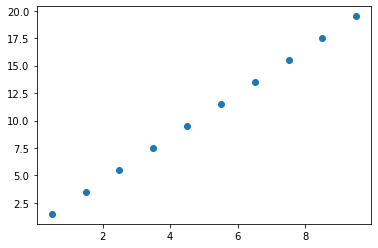

In [ ]:
plt.scatter(df_lin_mean.x, df_lin_mean.y)
plt.show()

In [ ]:
from sklearn import linear_model


class UnivarLinearReg(Operation):
  def __init__(self, x, y, grp):
    self.lm = linear_model.LinearRegression()
    # Delegate most of the computations to Mean Metrics.
    child = MetricList((Mean(x), Mean(y)))
    # Register grp as the extra_index.
    super(UnivarLinearReg, self).__init__(child, '%s ~ %s' % (y, x), grp)
    # For custom Metrics, class-level caching needs to be manually enabled.
    # See the Caching section for more information.
    self.cache_across_instances = True

  def split_data(self, df, split_by=None):
    """The 1st element in yield will be passed to compute()."""
    if not split_by:
      yield self.compute_child(df, self.extra_split_by), None
    else:
      # grp needs to come after split_by.
      child = self.compute_child(df, split_by + self.extra_split_by)
      keys, indices = list(zip(*child.groupby(split_by).groups.items()))
      for i, idx in enumerate(indices):
        yield child.loc[idx.unique()].droplevel(split_by), keys[i]

  def compute(self, df):
    self.lm.fit(df.iloc[:, [0]], df.iloc[:, 1])
    return pd.DataFrame([self.lm.coef_[0], self.lm.intercept_])


lr = UnivarLinearReg('x', 'y', 'grp')
Jackknife('cookie', lr, 0.95).compute_on(df_lin)

Metric     y ~ x                                      
           Value Jackknife CI-lower Jackknife CI-upper
0       2.000065           1.999928           2.000203
1       0.499577           0.498379           0.500775

In [ ]:
class UnivarLinearRegSlow(Metric):

  def __init__(self, x, y, grp):
    self.lm = linear_model.LinearRegression()
    # Doesn't delegate.
    self.x = x
    self.y = y
    self.grp = grp
    super(UnivarLinearRegSlow, self).__init__(
        '%s ~ %s' % (y, x), additional_fingerprint_attrs=['x', 'y', 'grp']
    )
    # For custom Metrics, class-level caching needs to be manually enabled.
    # See the Caching section for more information.
    self.cache_across_instances = True

  def split_data(self, df, split_by=None):
    """The 1st element in yield will be passed to compute()."""
    idx = split_by + [self.grp] if split_by else self.grp
    mean = df.groupby(idx).mean()
    if not split_by:
      yield mean, None
    else:
      keys, indices = list(zip(*mean.groupby(split_by).groups.items()))
      for i, idx in enumerate(indices):
        yield mean.loc[idx.unique()].droplevel(split_by), keys[i]

  def compute(self, df):
    self.lm.fit(df.iloc[:, [0]], df.iloc[:, 1])
    return pd.Series((self.lm.coef_[0], self.lm.intercept_))


lr_slow = UnivarLinearRegSlow('x', 'y', 'grp')
Jackknife('cookie', lr_slow, 0.95).compute_on(df_lin)

Metric     y ~ x                                      
           Value Jackknife CI-lower Jackknife CI-upper
0       2.000065           1.999928           2.000203
1       0.499577           0.498379           0.500775

In [ ]:
%%timeit
Jackknife('cookie', lr, 0.95).compute_on(df_lin)

1 loops, best of 5: 357 ms per loop


In [ ]:
%%timeit
Jackknife('cookie', lr_slow, 0.95).compute_on(df_lin)

1 loops, best of 5: 586 ms per loop


## LOWESS

In [ ]:
# Mimics that measurements, y, are taken repeatedly at a fixed grid, x.
np.random.seed(42)
size = 10
x = list(range(5))
df_sin = pd.DataFrame({'x': x * size, 'cookie': np.repeat(range(size), len(x))})
df_sin['y'] = np.sin(df_sin.x) + np.random.normal(scale=0.5, size=len(df_sin.x))

In [ ]:
import statsmodels.api as sm

lowess = sm.nonparametric.lowess


class Lowess(Metric):

  def __init__(self, x, y, name=None, where=None):
    self.x = x
    self.y = y
    name = name or 'LOWESS(%s ~ %s)' % (y, x)
    super(Lowess, self).__init__(
        name, where=where, additional_fingerprint_attrs=['x', 'y']
    )
    # For custom Metrics, class-level caching needs to be manually enabled.
    # See the Caching section for more information.
    self.cache_across_instances = True

  def compute(self, data):
    lowess_fit = pd.DataFrame(
        lowess(data[self.y], data[self.x]), columns=[self.x, self.y]
    )
    return lowess_fit.drop_duplicates().reset_index(drop=True)

In [ ]:
Lowess('x', 'y') | compute_on(df_sin)

,x,y
0,0.0,0.016953
1,1.0,0.592061
2,2.0,0.575784
3,3.0,-0.109848
4,4.0,-1.096083


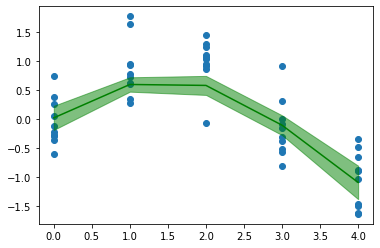

In [ ]:
jk = Lowess('x', 'y') | Jackknife('cookie', confidence=0.9) | compute_on(df_sin)
point_est = jk[('y', 'Value')]
ci_lower = jk[('y', 'Jackknife CI-lower')]
ci_upper = jk[('y', 'Jackknife CI-upper')]

plt.scatter(df_sin.x, df_sin.y)
plt.plot(x, point_est, c='g')
plt.fill_between(
    x, ci_lower,
    ci_upper,
    color='g',
    alpha=0.5)
plt.show()